# U-Net Segmentation

A more sophisticated approach is needed to segment the wires from the images. Multiple ones are available but the first one used is the U-Net. 



In [277]:
# import modules (download with pip install first if not on local. Type on terminal: pip install <module name>)
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use
import numpy as np

# install torchvision first
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print("Using",device,"...")

Using cuda:0 ...


## Dataset

In [163]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y = load_data('.', 'small_dataset')
# X, y = load_data('.', 'dataset')

In [164]:
from tqdm import tqdm

# implement Simulation of Dataset 
class SimDataset(Dataset):
    def __init__(self, count,mode,transform=None):

        if mode == '_train': 
            _simulated = X[0:int(count*X.shape[0])]
            _ground_truth = y[0:int(count*y.shape[0])]
        elif mode == '_val': 
            _simulated = X[-(int(count*X.shape[0])):]
            _ground_truth = y[-(int(count*y.shape[0])):]

        self.input_images, self.target_masks = np.array(_simulated), np.array(_ground_truth)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
            
        return [image, mask]

# Tranform into pytorch tensors 
trans = transforms.Compose([
    transforms.ToTensor(),
])

# Create a train set and a validation set, each with input images (simulation data) and target masks (ground truth data)
train_set = SimDataset(0.8,'_train',transform = trans)
val_set = SimDataset(0.2,'_val',transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 50

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

print(dataset_sizes)

{'train': 1600, 'val': 400}


In [291]:
from scipy.ndimage import gaussian_filter

def norm(im):
    im = im - np.min(im)
    im = im / np.max(im)
    return im

def modify_gts(gts):
    gts_smoothed = [(gaussian_filter(gt, sigma = 0.15) > 0).astype(np.int) for gt in gts]
#     gts = [(1 - gaussian_filter(gt, sigma = 5)) ** (-0.03) for gt in gts]
#     for i in range(len(gts_smoothed)):
#         gt = gts_smoothed[i]
# #         gt[gt > 0] = (1 - gt[gt > 0]) ** (-3)
#         gts_smoothed[i] = gt - np.min(gt)
#         gts_smoothed[i] = gt / np.max(gt)
    return gts_smoothed

(128, 64)


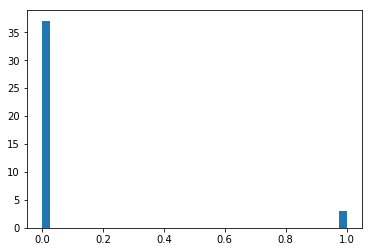

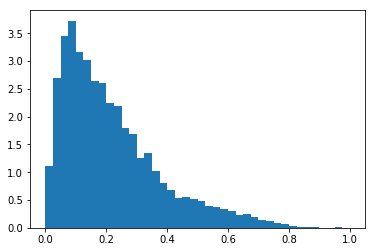

Class balance (one sigma):  7.3486328125 %
Loss for null model: 0.06808613240718842


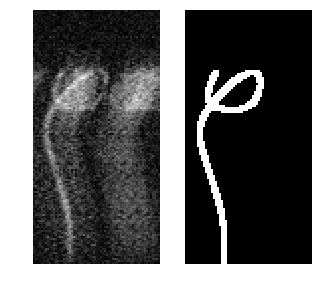

Class balance (one sigma):  7.0556640625 %
Loss for null model: 0.06557835638523102


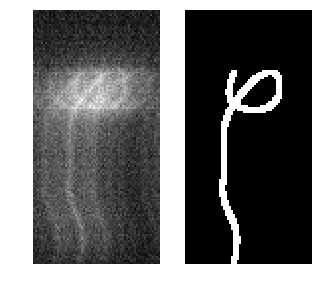

Class balance (one sigma):  7.55615234375 %
Loss for null model: 0.06985192000865936


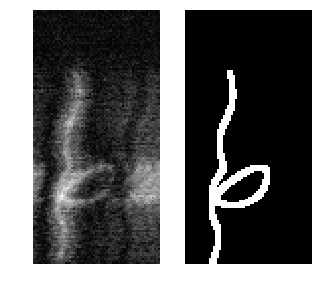

In [289]:
import matplotlib.pyplot as plt

loss_function = nn.MSELoss()

def show(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')

print(dataloaders['train'])
n = 3
first_batch = next(iter(dataloaders['train']))

ims = first_batch[0][:n]
gts = modify_gts(first_batch[1][:n])
# gts = first_batch[1][:n].numpy()

print(gts[0].shape)
h2 = plt.hist(gts[0].reshape(-1,1), bins = 40, density = True, alpha=1)
plt.show()
h2 = plt.hist(ims[0].numpy().reshape(-1,1), bins = 40, density = True, alpha=1)
plt.show()

for [im], gt in zip(ims, gts):
    plt.figure(figsize=[5]*2)
    plt.subplot(121)
    show(im)

    plt.subplot(122)
    show(gt)

    base_loss = loss_function(torch.Tensor(np.ones(gt.shape) * np.average(gt)), torch.Tensor(gt))
    print('Class balance (one sigma): ', 100 * np.sum((gt - np.std(gt)) > 0) / np.prod(gt.shape), '%')
    print('Loss for null model:', base_loss.item())
    
    plt.show()

## Model

In [183]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
print(inputs.dtype, masks.dtype)

for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

# install torchsummary first
from torchsummary import summary
# import model from python file
import Unet_pytorch
import importlib
importlib.reload(Unet_pytorch)

model = Unet_pytorch.UNet(1)
model = model.to(device)

print("MODEL ARCHITECTURE ...")
summary(model, input_size=(1,128,64))

torch.Size([50, 1, 128, 64]) torch.Size([50, 128, 64])
torch.float64 torch.float64
0.0001725283728127341 1.0 0.25933406851620555 0.1708294135025163
0.0 1.0 0.02400146484375 0.15305356751511623
MODEL ARCHITECTURE ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 64]             320
       BatchNorm2d-2          [-1, 32, 128, 64]              64
              ReLU-3          [-1, 32, 128, 64]               0
            Conv2d-4          [-1, 32, 128, 64]           9,248
       BatchNorm2d-5          [-1, 32, 128, 64]              64
              ReLU-6          [-1, 32, 128, 64]               0
         MaxPool2d-7           [-1, 32, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          18,496
       BatchNorm2d-9           [-1, 64, 64, 32]             128
             ReLU-10           [-1, 64, 64, 32]               0
           Conv

## Training

In [278]:
from torch.utils.tensorboard import SummaryWriter
import datetime
writer = SummaryWriter('./logs/{0}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

import matplotlib.pyplot as plt
def visualise(outputs, n=7):
    plt.figure(figsize=[10, 3])
    for i, output in enumerate(outputs[:n]):
        plt.subplot(1,n,i+1)
        pred = output[0].cpu().numpy()
        plt.axis('off')
        plt.imshow(pred, cmap='gray')
    plt.show()

Epoch 0/99
----------
LR 0.01
Batch 0 : 0.24813522398471832
Batch 10 : 0.14987973868846893
Batch 20 : 0.08016134053468704
Batch 30 : 0.05481669306755066
Loss train : 0.12417367
Batch 0 : 0.07415413856506348
Loss val : 0.07465595
torch.Size([50, 1, 128, 64])


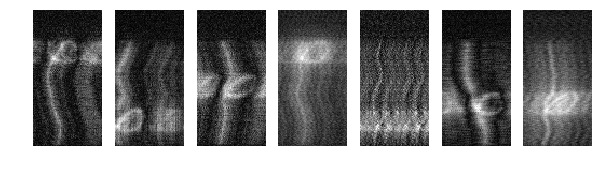

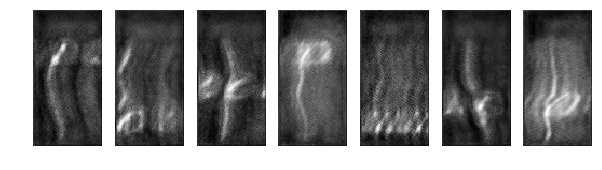

saving best model
0m 6s
Epoch 1/99
----------
LR 0.01
Batch 0 : 0.05159085988998413
Batch 10 : 0.043967001140117645
Batch 20 : 0.03893811255693436
Batch 30 : 0.03589240834116936
Loss train : 0.04190538
Batch 0 : 0.036242347210645676
Loss val : 0.03558673
torch.Size([50, 1, 128, 64])


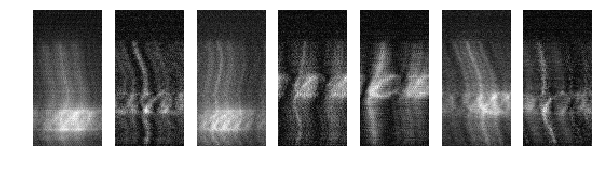

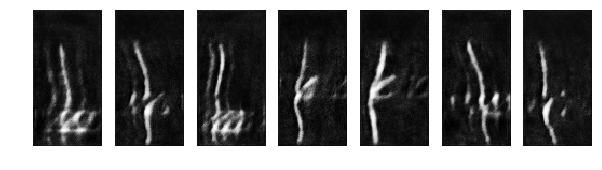

saving best model
0m 6s
Epoch 2/99
----------
LR 0.01
Batch 0 : 0.03411800414323807
Batch 10 : 0.031266387552022934
Batch 20 : 0.02944805845618248
Batch 30 : 0.027812117710709572
Loss train : 0.03069030
Batch 0 : 0.029987582936882973
Loss val : 0.02780192
torch.Size([50, 1, 128, 64])


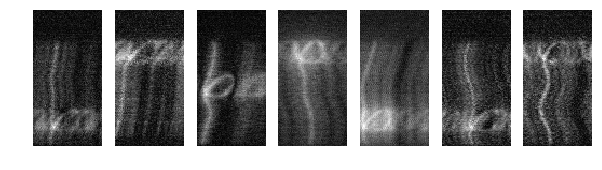

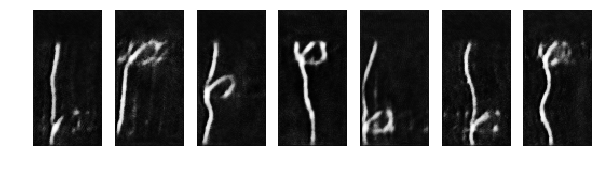

saving best model
0m 6s
Epoch 3/99
----------
LR 0.01
Batch 0 : 0.02827964909374714
Batch 10 : 0.02512369118630886
Batch 20 : 0.025247670710086823
Batch 30 : 0.024539558216929436
Loss train : 0.02526814
Batch 0 : 0.024162225425243378
Loss val : 0.02399672
torch.Size([50, 1, 128, 64])


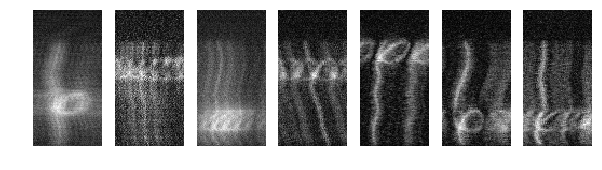

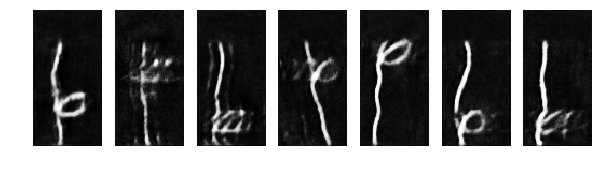

saving best model
0m 6s
Epoch 4/99
----------
LR 0.01
Batch 0 : 0.02233710326254368
Batch 10 : 0.02285161055624485
Batch 20 : 0.0217671487480402
Batch 30 : 0.021251535043120384
Loss train : 0.02166285
Batch 0 : 0.020855635404586792
Loss val : 0.02097268
torch.Size([50, 1, 128, 64])


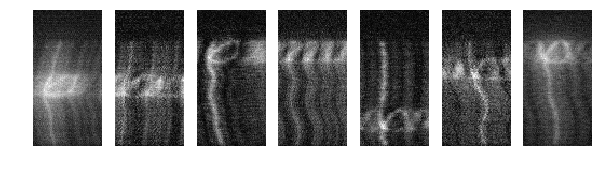

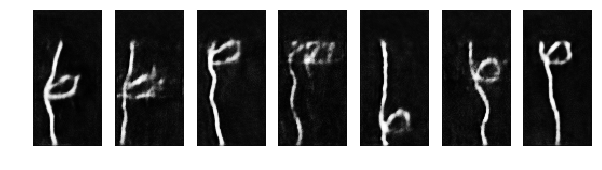

saving best model
0m 6s
Epoch 5/99
----------
LR 0.01
Batch 0 : 0.022519277408719063
Batch 10 : 0.01936514489352703
Batch 20 : 0.019878964871168137
Batch 30 : 0.018627557903528214
Loss train : 0.01916399
Batch 0 : 0.019188566133379936
Loss val : 0.01883607
torch.Size([50, 1, 128, 64])


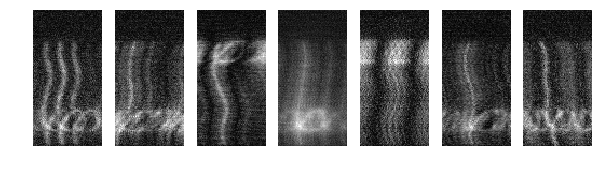

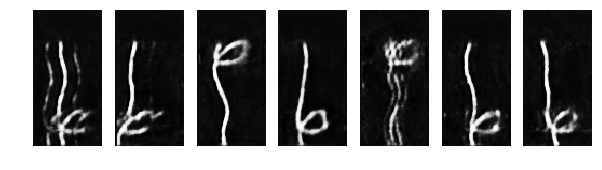

saving best model
0m 6s
Epoch 6/99
----------
LR 0.01
Batch 0 : 0.01820843107998371
Batch 10 : 0.017657240852713585
Batch 20 : 0.017221076413989067
Batch 30 : 0.01665252074599266
Loss train : 0.01725595
Batch 0 : 0.016850579530000687
Loss val : 0.01745717
torch.Size([50, 1, 128, 64])


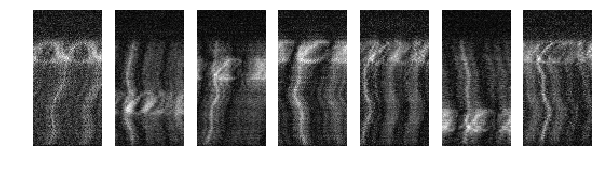

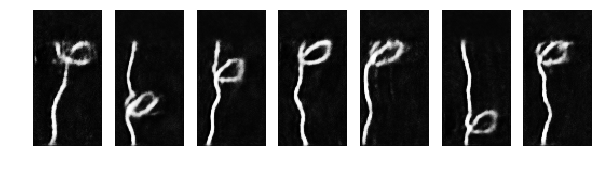

saving best model
0m 6s
Epoch 7/99
----------
LR 0.01
Batch 0 : 0.017705587670207024
Batch 10 : 0.014772281050682068
Batch 20 : 0.014714076183736324
Batch 30 : 0.014179742895066738
Loss train : 0.01582328
Batch 0 : 0.016765939071774483
Loss val : 0.01625945
torch.Size([50, 1, 128, 64])


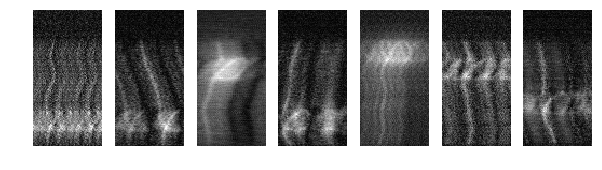

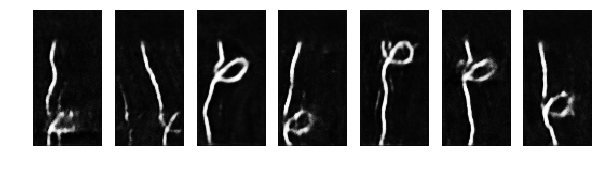

saving best model
0m 6s
Epoch 8/99
----------
LR 0.01
Batch 0 : 0.016790810972452164
Batch 10 : 0.0148733826354146
Batch 20 : 0.014928121119737625
Batch 30 : 0.013656184077262878
Loss train : 0.01456560
Batch 0 : 0.016313333064317703
Loss val : 0.01524356
torch.Size([50, 1, 128, 64])


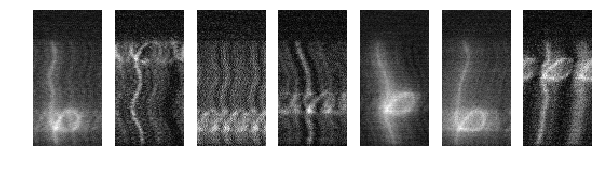

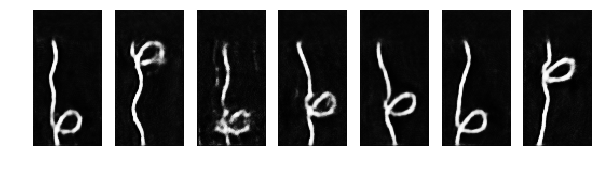

saving best model
0m 7s
Epoch 9/99
----------
LR 0.01
Batch 0 : 0.013730037026107311
Batch 10 : 0.01359483227133751
Batch 20 : 0.013139422982931137
Batch 30 : 0.012899033725261688
Loss train : 0.01361185
Batch 0 : 0.013856105506420135
Loss val : 0.01441908
torch.Size([50, 1, 128, 64])


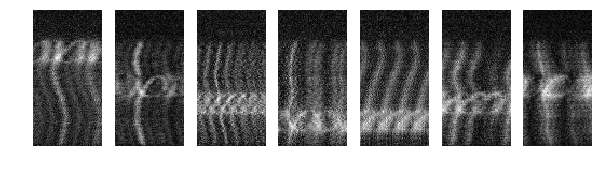

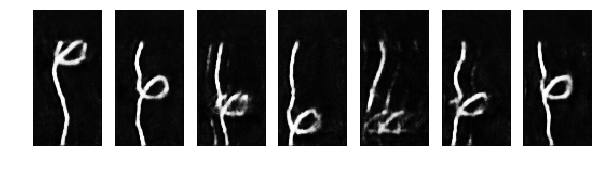

saving best model
0m 7s
Epoch 10/99
----------
LR 0.01
Batch 0 : 0.013138294219970703
Batch 10 : 0.012462235055863857
Batch 20 : 0.012971495278179646
Batch 30 : 0.013166246004402637
Loss train : 0.01276393
Batch 0 : 0.013914010487496853
Loss val : 0.01379081
torch.Size([50, 1, 128, 64])


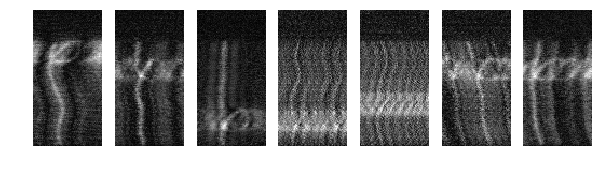

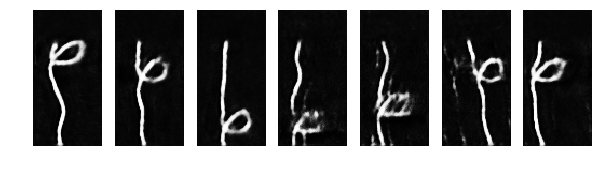

saving best model
0m 6s
Epoch 11/99
----------
LR 0.01
Batch 0 : 0.012344741262495518
Batch 10 : 0.011575056239962578
Batch 20 : 0.011479456909000874
Batch 30 : 0.011277781799435616
Loss train : 0.01202289
Batch 0 : 0.01258179359138012
Loss val : 0.01328531
torch.Size([50, 1, 128, 64])


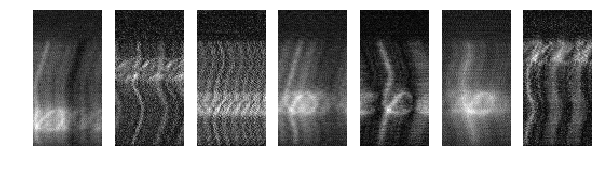

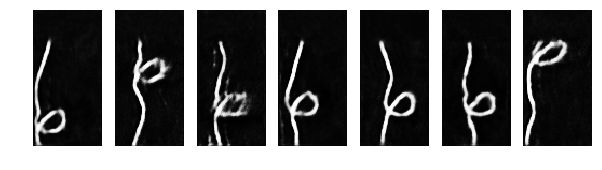

saving best model
0m 6s
Epoch 12/99
----------
LR 0.01
Batch 0 : 0.01117152813822031
Batch 10 : 0.011311578564345837
Batch 20 : 0.011548604816198349
Batch 30 : 0.011406523175537586
Loss train : 0.01137336
Batch 0 : 0.013176467269659042
Loss val : 0.01275272
torch.Size([50, 1, 128, 64])


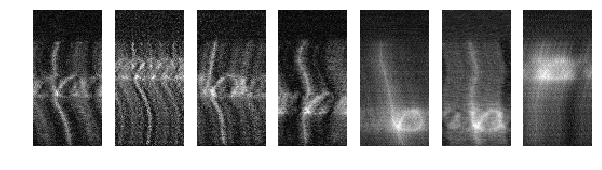

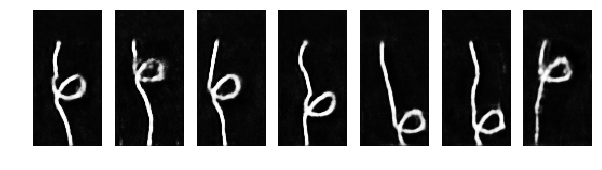

saving best model
0m 6s
Epoch 13/99
----------
LR 0.01
Batch 0 : 0.011833259835839272
Batch 10 : 0.010374929755926132
Batch 20 : 0.011068935506045818
Batch 30 : 0.010372873395681381
Loss train : 0.01079642
Batch 0 : 0.012500092387199402
Loss val : 0.01237593
torch.Size([50, 1, 128, 64])


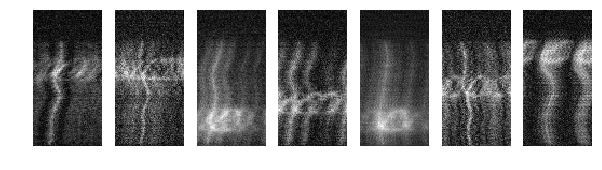

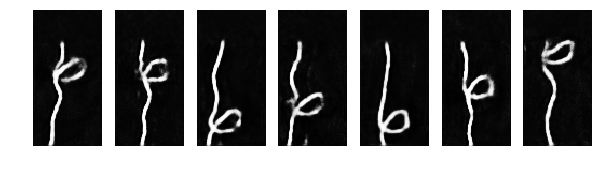

saving best model
0m 6s
Epoch 14/99
----------
LR 0.01
Batch 0 : 0.01104798074811697
Batch 10 : 0.010924279689788818
Batch 20 : 0.010743606835603714
Batch 30 : 0.009488008916378021
Loss train : 0.01036502
Batch 0 : 0.012122968211770058
Loss val : 0.01204461
torch.Size([50, 1, 128, 64])


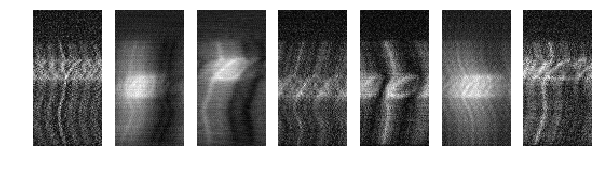

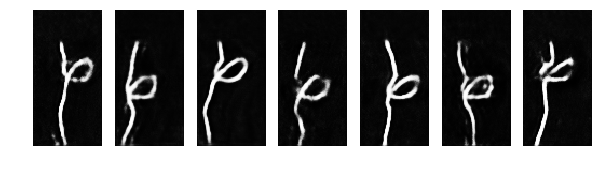

saving best model
0m 6s
Epoch 15/99
----------
LR 0.01
Batch 0 : 0.009407499805092812
Batch 10 : 0.00896996259689331
Batch 20 : 0.010113311000168324
Batch 30 : 0.009619737975299358
Loss train : 0.00989992
Batch 0 : 0.012685123831033707
Loss val : 0.01164253
torch.Size([50, 1, 128, 64])


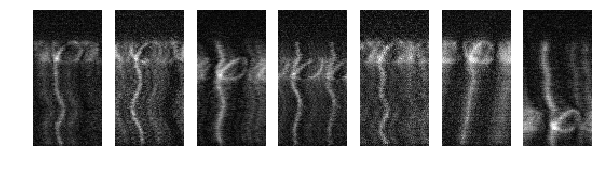

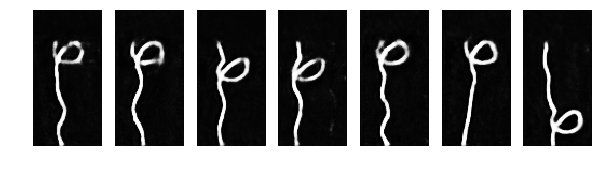

saving best model
0m 6s
Epoch 16/99
----------
LR 0.01
Batch 0 : 0.009019427001476288
Batch 10 : 0.009241211228072643
Batch 20 : 0.00948144868016243
Batch 30 : 0.009943417273461819
Loss train : 0.00950334
Batch 0 : 0.010958518832921982
Loss val : 0.01156968
torch.Size([50, 1, 128, 64])


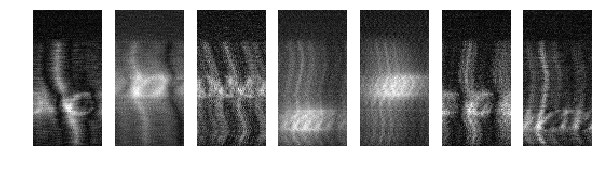

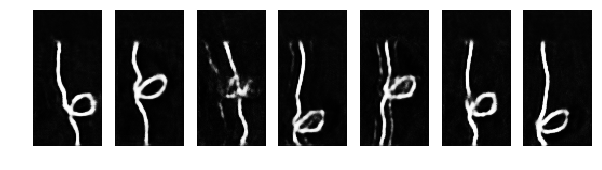

saving best model
0m 6s
Epoch 17/99
----------
LR 0.01
Batch 0 : 0.009962516836822033
Batch 10 : 0.009584462270140648
Batch 20 : 0.008549214340746403
Batch 30 : 0.009404374286532402
Loss train : 0.00910321
Batch 0 : 0.010216627269983292
Loss val : 0.01113103
torch.Size([50, 1, 128, 64])


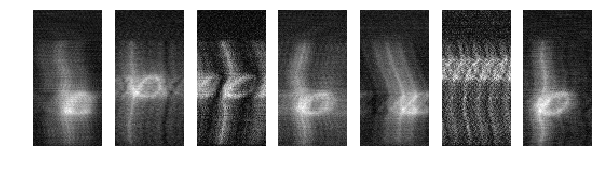

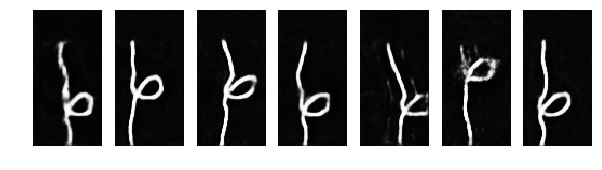

saving best model
0m 6s
Epoch 18/99
----------
LR 0.01
Batch 0 : 0.008983204141259193
Batch 10 : 0.008743872866034508
Batch 20 : 0.00864717923104763
Batch 30 : 0.009059950709342957
Loss train : 0.00883636
Batch 0 : 0.010266304016113281
Loss val : 0.01092274
torch.Size([50, 1, 128, 64])


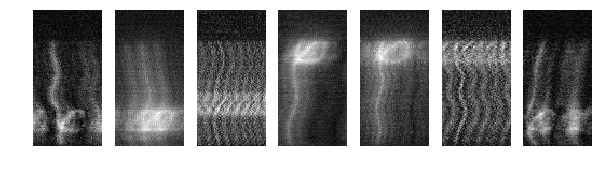

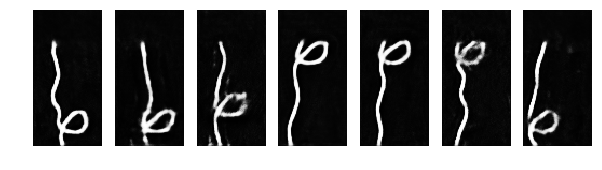

saving best model
0m 6s
Epoch 19/99
----------
LR 0.01
Batch 0 : 0.00831470638513565
Batch 10 : 0.008735379204154015
Batch 20 : 0.00824861042201519
Batch 30 : 0.008473464287817478
Loss train : 0.00853940
Batch 0 : 0.010813207365572453
Loss val : 0.01070488
torch.Size([50, 1, 128, 64])


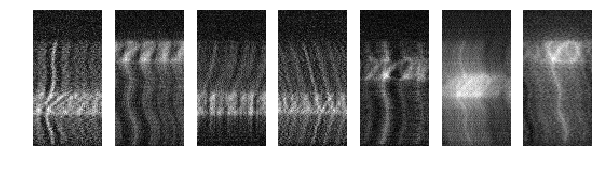

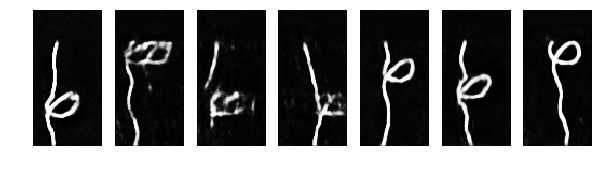

saving best model
0m 6s
Epoch 20/99
----------
LR 0.01
Batch 0 : 0.0083460146561265
Batch 10 : 0.008142774924635887
Batch 20 : 0.008030135184526443
Batch 30 : 0.008036709390580654
Loss train : 0.00823594
Batch 0 : 0.010365581139922142
Loss val : 0.01068575
torch.Size([50, 1, 128, 64])


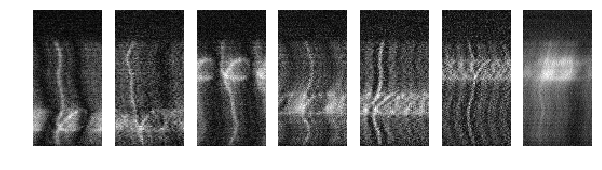

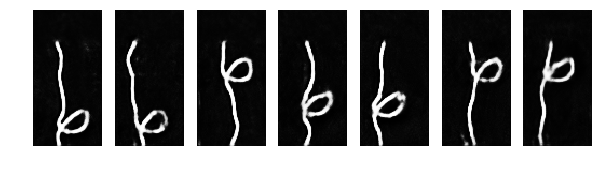

saving best model
0m 6s
Epoch 21/99
----------
LR 0.01
Batch 0 : 0.008517984300851822
Batch 10 : 0.008296800777316093
Batch 20 : 0.007967122830450535
Batch 30 : 0.007855743169784546
Loss train : 0.00797408
Batch 0 : 0.01029994897544384
Loss val : 0.01038347
torch.Size([50, 1, 128, 64])


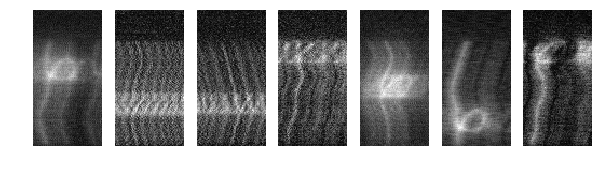

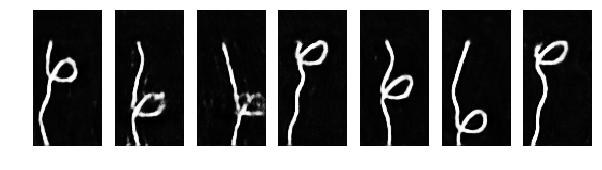

saving best model
0m 6s
Epoch 22/99
----------
LR 0.01
Batch 0 : 0.007490665186196566
Batch 10 : 0.008138521574437618
Batch 20 : 0.008020982146263123
Batch 30 : 0.007530106231570244
Loss train : 0.00777340
Batch 0 : 0.01060730405151844
Loss val : 0.01027027
torch.Size([50, 1, 128, 64])


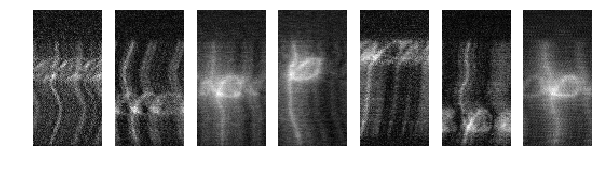

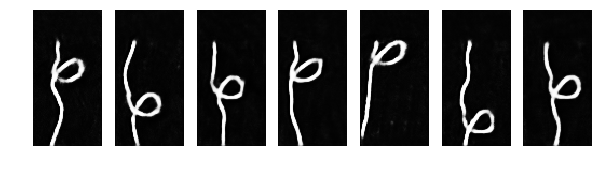

saving best model
0m 6s
Epoch 23/99
----------
LR 0.01
Batch 0 : 0.007896356284618378
Batch 10 : 0.007507371250540018
Batch 20 : 0.007682502269744873
Batch 30 : 0.007512792944908142
Loss train : 0.00753279
Batch 0 : 0.010176814161241055
Loss val : 0.01015238
torch.Size([50, 1, 128, 64])


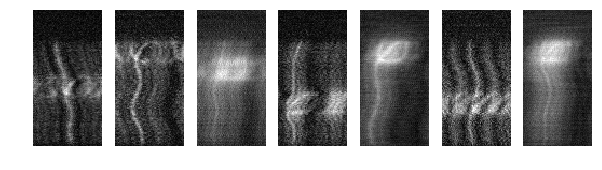

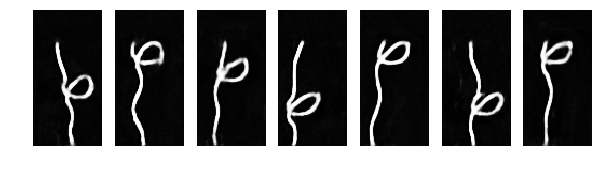

saving best model
0m 6s
Epoch 24/99
----------
LR 0.01
Batch 0 : 0.007632828783243895
Batch 10 : 0.007417863234877586
Batch 20 : 0.007494064513593912
Batch 30 : 0.007115647196769714
Loss train : 0.00731865
Batch 0 : 0.01037346851080656
Loss val : 0.00998069
torch.Size([50, 1, 128, 64])


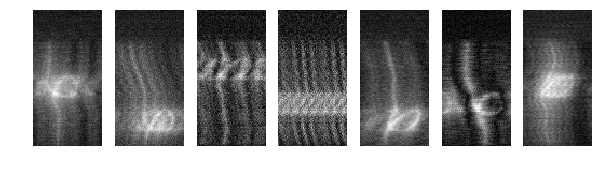

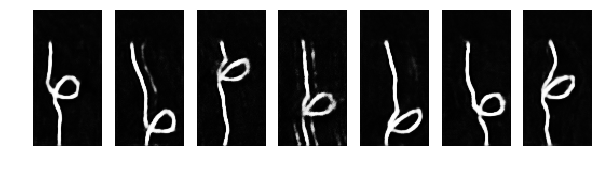

saving best model
0m 6s
Epoch 25/99
----------
LR 0.01
Batch 0 : 0.007191864307969809
Batch 10 : 0.007250852417200804
Batch 20 : 0.007551403250545263
Batch 30 : 0.0070563689805567265
Loss train : 0.00713341
Batch 0 : 0.00929646659642458
Loss val : 0.00990828
torch.Size([50, 1, 128, 64])


KeyboardInterrupt: 

In [282]:
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy
save_path = './saved_models/model_1'

def train_model(model, optimizer, scheduler = None, num_epochs=25, train_stats_period=10):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() if scheduler is not None else None
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            loss_vec = []

            for batch_id, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = torch.Tensor(modify_gts(labels))
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    loss = loss_function(torch.squeeze(outputs), labels.type(torch.float32))
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (loss.item())
                    loss_vec.append(loss.item())  

                    if batch_id % train_stats_period == 0:
                        print('Batch', batch_id, ':', loss.item())

                # statistics
                epoch_samples += inputs.size(0)

            # print loss at every epoch 
            epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)
            #epoch_loss = np.mean(np.asarray(loss_vec), dtype=np.float32)/float(epoch_samples)
            print('Loss ' + phase, ': {:.8f}'.format(epoch_loss))
            writer.add_scalar('Loss ' + phase, epoch_loss, epoch)

            if phase == 'val':
                print(outputs.shape)
                visualise(inputs)
                visualise(outputs)
                
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                torch.save(model.state_dict(), save_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

num_class = 1
model = Unet_pytorch.UNet(num_class).float()
model = model.to(device)

optimizer_ft = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9) 

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

train_model(model, optimizer_ft, num_epochs=100)

## Evaluate on <u>real</u> data

Performance on real data


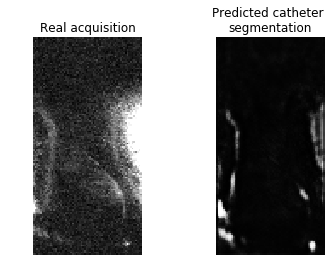

In [302]:
model.load_state_dict(torch.load(save_path))
model = model.to(device)
model.eval()

def infer(model, im):
    im = torch.Tensor(im).unsqueeze(0).unsqueeze(0).to(device)
    return model(im).squeeze(0).squeeze(0).cpu().detach().numpy()

print('Performance on real data')
import imageio
gif = imageio.get_reader('cropped_gif.gif')
test_im = np.array(list(gif))[100]
test_im = norm(np.array(Image.fromarray(test_im).resize([64, 128])))
plt.subplot(121)
show(test_im)
plt.title('Real acquisition')

# test_im = torch.Tensor(ims[0].float()).unsqueeze(0).to(device)
test_pred = infer(model, test_im)
plt.subplot(122)
show(test_pred)
plt.title('Predicted catheter \nsegmentation')
plt.show()